# Price Optimization for Predicted Daily Revenue

## Introduction
 
In this project, we explore a price optimization model applied to a dataset of CPU coolers. The goal is to analyze and optimize prices across various promotional events to maximize revenue. We use Generalized Additive Models (GAMs) for predicting optimal prices and expected sales. GAMs allow for flexible, non-linear relationships between predictors (like price) and response variables (like quantity sold), which is particularly useful for capturing the complexities in demand across various price points.

This report outlines the data simulation, exploratory data analysis (EDA), and modeling approach to identify optimal pricing for each product. Finally, we showcase results from our GAM-based price optimization model.

In [450]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date

# Modeling
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

# Visualization
import plotly.express as px
from plotnine import *
import textwrap

# Set a global style
sns.set(style="whitegrid")
palette = sns.color_palette("pastel")

import warnings
warnings.filterwarnings('ignore')

## Data Simulation and Preparation

The dataset was simulated to reflect realistic patterns of demand and price decay for six CPU cooler products across different promotional events. Significant promotional events, such as "Black Friday" and "Amazon Prime Day," were also included to observe their impact on price sensitivity.

Key fields in the dataset:
- `price`: Adjusted product price considering discounts and seasonal decay.
- `quantity_sold`: Units sold, adjusted based on price elasticity and event-driven demand shifts.
- `event`: Promotional event associated with price discounts.
- `profit`: Calculated based on price and base profit margin.

In [451]:
# Set date range for two years
start_date = pd.Timestamp(date(2022, 1, 1))  
end_date = pd.Timestamp(date(2023, 12, 31))
date_range = pd.date_range(start_date, end_date)

In [452]:
# Define CPU coolers and categories with unique parameters
products = [
    {"product_name": "Noctua NH-D15", "category": "Air Cooler", "base_price": 89.99, "base_profit_margin": 0.3,
     "base_demand": 1300, "price_elasticity": 0.15, "event_sensitivity": 1.1, "quality": "high", "competition_factor": 1.0},
    {"product_name": "Dark Rock Pro 4", "category": "Air Cooler", "base_price": 79.99, "base_profit_margin": 0.28,
     "base_demand": 1200, "price_elasticity": 0.2, "event_sensitivity": 1.2, "quality": "medium", "competition_factor": 1.1},
    {"product_name": "Corsair H100i", "category": "Liquid AIO Cooler", "base_price": 129.99, "base_profit_margin": 0.35,
     "base_demand": 1000, "price_elasticity": 0.1, "event_sensitivity": 1.3, "quality": "high", "competition_factor": 0.9},
    {"product_name": "NZXT Kraken X63", "category": "Liquid AIO Cooler", "base_price": 139.99, "base_profit_margin": 0.33,
     "base_demand": 900, "price_elasticity": 0.12, "event_sensitivity": 1.4, "quality": "medium", "competition_factor": 1.05},
    {"product_name": "EKWB EK-KIT P240", "category": "Custom Liquid Cooler", "base_price": 239.99, "base_profit_margin": 0.4,
     "base_demand": 700, "price_elasticity": 0.2, "event_sensitivity": 1.2, "quality": "low", "competition_factor": 1.2},
    {"product_name": "Thermaltake Pacific CL360", "category": "Custom Liquid Cooler", "base_price": 299.99,
     "base_profit_margin": 0.42, "base_demand": 1100, "price_elasticity": 0.2, "event_sensitivity": 1.25, "quality": "low",
     "competition_factor": 1.15}
]

In [453]:
# Define significant promotional events with date ranges
events = {
    "New Year's Sale": ["2022-01-01", "2022-01-14", "2023-01-01", "2023-01-14"],
    "Valentine's Day": ["2022-02-07", "2022-02-21", "2023-02-07", "2023-02-21"],
    "Easter": ["2022-04-10", "2022-04-24", "2023-04-02", "2023-04-16"],
    "Mother's Day": ["2022-05-01", "2022-05-15", "2023-05-01", "2023-05-15"],
    "Amazon Prime Day": ["2022-07-11", "2022-07-24", "2023-07-10", "2023-07-23"],
    "Back-to-School": ["2022-08-01", "2022-08-14", "2023-08-01", "2023-08-14"],
    "Black Friday": ["2022-11-18", "2022-12-02", "2023-11-17", "2023-12-01"],
    "Christmas": ["2022-12-12", "2022-12-25", "2023-12-11", "2023-12-25"]
}

# Assign different discount ranges for each event
discount_ranges = {
    "New Year's Sale": (5, 10),
    "Valentine's Day": (3, 7),
    "Easter": (3, 8),
    "Mother's Day": (2, 5),
    "Amazon Prime Day": (10, 15),
    "Back-to-School": (3, 5),
    "Black Friday": (15, 20),
    "Christmas": (10, 15),
    "No Promo": (0, 3)
}


# New product launch dates to simulate additional price drops
launch_dates = [date(2022, 7, 1), date(2023, 1, 1), date(2023, 7, 1)]

In [454]:
# Generate event labels for each date
def get_event_label(current_date):
    for event, dates in events.items():
        for i in range(0, len(dates), 2):
            if pd.to_datetime(dates[i]) <= current_date <= pd.to_datetime(dates[i+1]):
                return event
    return "No Promo"

In [455]:
# Generate dataset with optimized patterns for each product, focusing on smooth demand and price decay
data_list = []
np.random.seed(0)  # For reproducibility

for single_date in date_range:
    for product in products:
        event = get_event_label(single_date)

        # Apply discount based on event-specific range
        discount_range = discount_ranges.get(event)  # Get the discount range for the event
        discount = np.random.randint(discount_range[0], discount_range[1] + 1)  # Random discount within range

        # Calculate the price after applying the discount and a gradual price decay over time for "No Promo" days
        if event == "No Promo":
            weeks_since_start = (single_date - start_date).days // 7
            price_decay = max(0.5, 1 - 0.0005 * weeks_since_start)  # Smaller decay rate for smoother price changes
            price = product["base_price"] * price_decay * (1 - discount / 100)
            price *= np.random.uniform(0.99, 1.01)  # Minor daily price variability
        else:
            price = product["base_price"] * (1 - discount / 100)
        
        # Adjust base demand inversely related to price and based on product's price elasticity
        base_demand = product["base_demand"] - (price * product["price_elasticity"])

        # Adjust demand for events, increasing predictability and smoothness
        event_multiplier = 1 + (discount / 100) * product["event_sensitivity"]
        units_sold = base_demand * event_multiplier

        # Reduce the noise level for smoother patterns
        units_sold = int(units_sold * np.random.uniform(0.98, 1.02))  # +/-2% variability

        # Calculate profit
        profit_margin = product["base_profit_margin"]
        profit = (price - (product["base_price"] * (1 - profit_margin))) * units_sold

        # Append data to list
        data_list.append({
            "date": single_date,
            "product": product["product_name"],
            "category": product["category"],
            "price": round(price, 2),
            "discount": f"{discount}%",
            "quantity_sold": max(int(units_sold), 0),  # Ensure no negative units
            "profit": round(profit, 2),
            "profit_margin": product["base_profit_margin"],
            "event": event
        })

In [456]:
# Create DataFrame
data = pd.DataFrame(data_list)
data.to_csv("cpu_cooler_sales_data.csv", index=False)
data

date                    product              category   price  \
0    2022-01-01              Noctua NH-D15            Air Cooler   81.89   
1    2022-01-01            Dark Rock Pro 4            Air Cooler   75.99   
2    2022-01-01              Corsair H100i     Liquid AIO Cooler  119.59   
3    2022-01-01            NZXT Kraken X63     Liquid AIO Cooler  128.79   
4    2022-01-01           EKWB EK-KIT P240  Custom Liquid Cooler  218.39   
...         ...                        ...                   ...     ...   
4375 2023-12-31            Dark Rock Pro 4            Air Cooler   74.62   
4376 2023-12-31              Corsair H100i     Liquid AIO Cooler  123.54   
4377 2023-12-31            NZXT Kraken X63     Liquid AIO Cooler  128.94   
4378 2023-12-31           EKWB EK-KIT P240  Custom Liquid Cooler  222.77   
4379 2023-12-31  Thermaltake Pacific CL360  Custom Liquid Cooler  281.72   

     discount  quantity_sold     profit  profit_margin            event  
0          9%           1420   26835.02           0.30  New Year's Sale  
1          5%           1261   23199.50           0.28  New Year's Sale  
2          8%           1105   38782.52           0.35  New Year's Sale  
3          8%            989   34612.53           0.33  New Year's Sale  
4          9%            721   53640.16           0.40  New Year's Sale  
...       ...            ...        ...            ...              ...  
4375       1%           1185   20175.31           0.28         No Promo  
4376       0%           1001   39084.61           0.35         No Promo  
4377       2%            905   31810.24           0.33         No Promo  
4378       3%            679   53485.78           0.40         No Promo  
4379       0%           1028  110737.19           0.42         No Promo  

[4380 rows x 9 columns]

## Exploratory Data Analysis (EDA)
 
EDA was conducted to assess the relationship between `price` and `quantity_sold`, including:
- **Price vs Quantity Sold**: A scatter plot showing the inverse relationship between price and quantity sold for different products.
- **Event Analysis**: This plot illustrates the impact of promotional events on sales volume, which is critical for understanding event-driven price sensitivity.


In [457]:
data.describe(include='all')

date        product    category        price discount  \
count                  4380           4380        4380  4380.000000     4380   
unique                  NaN              6           3          NaN       21   
top                     NaN  Noctua NH-D15  Air Cooler          NaN       3%   
freq                    NaN            730        1460          NaN      936   
mean    2022-12-31 12:00:00            NaN         NaN   154.388817      NaN   
min     2022-01-01 00:00:00            NaN         NaN    63.990000      NaN   
25%     2022-07-02 00:00:00            NaN         NaN    85.877500      NaN   
50%     2022-12-31 12:00:00            NaN         NaN   127.365000      NaN   
75%     2023-07-02 00:00:00            NaN         NaN   229.232500      NaN   
max     2023-12-31 00:00:00            NaN         NaN   302.140000      NaN   
std                     NaN            NaN         NaN    76.123437      NaN   

        quantity_sold         profit  profit_margin     event  
count     4380.000000    4380.000000    4380.000000      4380  
unique            NaN            NaN            NaN         9  
top               NaN            NaN            NaN  No Promo  
freq              NaN            NaN            NaN      2982  
mean      1052.855936   50281.147998       0.346667       NaN  
min        639.000000    9381.230000       0.280000       NaN  
25%        912.750000   29410.162500       0.300000       NaN  
50%       1055.000000   37965.395000       0.340000       NaN  
75%       1226.000000   57267.855000       0.400000       NaN  
max       1599.000000  132998.360000       0.420000       NaN  
std        220.068178   32799.855144       0.050227       NaN

In [458]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4380 non-null   datetime64[ns]
 1   product        4380 non-null   object        
 2   category       4380 non-null   object        
 3   price          4380 non-null   float64       
 4   discount       4380 non-null   object        
 5   quantity_sold  4380 non-null   int64         
 6   profit         4380 non-null   float64       
 7   profit_margin  4380 non-null   float64       
 8   event          4380 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 308.1+ KB


In [459]:
# 2.0 DATA PREPARATION
data['is_event'] = (data['event'] != "No Promo").astype(int).astype(str)
data['revenue'] = data['price'] * data['quantity_sold']
data

date                    product              category   price  \
0    2022-01-01              Noctua NH-D15            Air Cooler   81.89   
1    2022-01-01            Dark Rock Pro 4            Air Cooler   75.99   
2    2022-01-01              Corsair H100i     Liquid AIO Cooler  119.59   
3    2022-01-01            NZXT Kraken X63     Liquid AIO Cooler  128.79   
4    2022-01-01           EKWB EK-KIT P240  Custom Liquid Cooler  218.39   
...         ...                        ...                   ...     ...   
4375 2023-12-31            Dark Rock Pro 4            Air Cooler   74.62   
4376 2023-12-31              Corsair H100i     Liquid AIO Cooler  123.54   
4377 2023-12-31            NZXT Kraken X63     Liquid AIO Cooler  128.94   
4378 2023-12-31           EKWB EK-KIT P240  Custom Liquid Cooler  222.77   
4379 2023-12-31  Thermaltake Pacific CL360  Custom Liquid Cooler  281.72   

     discount  quantity_sold     profit  profit_margin            event  \
0          9%           1420   26835.02           0.30  New Year's Sale   
1          5%           1261   23199.50           0.28  New Year's Sale   
2          8%           1105   38782.52           0.35  New Year's Sale   
3          8%            989   34612.53           0.33  New Year's Sale   
4          9%            721   53640.16           0.40  New Year's Sale   
...       ...            ...        ...            ...              ...   
4375       1%           1185   20175.31           0.28         No Promo   
4376       0%           1001   39084.61           0.35         No Promo   
4377       2%            905   31810.24           0.33         No Promo   
4378       3%            679   53485.78           0.40         No Promo   
4379       0%           1028  110737.19           0.42         No Promo   

     is_event    revenue  
0           1  116283.80  
1           1   95823.39  
2           1  132146.95  
3           1  127373.31  
4           1  157459.19  
...       ...        ...  
4375        0   88424.70  
4376        0  123663.54  
4377        0  116690.70  
4378        0  151260.83  
4379        0  289608.16  

[4380 rows x 11 columns]

In [460]:
# Plot: Price vs Quantity Sold
fig = px.scatter(
    data,  # Your DataFrame
    x='price',
    y='quantity_sold',
    color='product',
    opacity=0.6,
    trendline="lowess",
    trendline_color_override="blue",
    template="none",
    title="Product Sales: Price vs Quantity Analysis",
    width=1000,
    height=600,
)

# Customize marker and hover labels
fig.update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10))
)

# Customize layout
fig.update_layout(
    legend_title_text="Product",
    title_font=dict(size=16),
    legend_font=dict(size=10)
)

# Customize x-axis
fig.update_xaxes(
    title_text="Price",
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

# Customize y-axis
fig.update_yaxes(
    title_text="Quantity Sold",
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

# Show the figure
fig.show()

## Event analysis (Outliers)

In [461]:
# Scatter Plot
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color='event',
    facet_col='product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.1,
    opacity=0.6,
    trendline="lowess",
    trendline_color_override="blue",
    template="none",
    title="Product Sales: Event Analysis",
    width=900,
    height=900,
)

# Customize marker and hover labels
fig.update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10))
)

# Customize layout
fig.update_layout(
    legend_title_text="Product",
    title_font=dict(size=16),
    legend_font=dict(size=10)
)

# Customize x-axis
fig.update_xaxes(
    title_text="Price",
    title_font=dict(size=10),
    tickfont=dict(size=10),
    matches=None
)

# Customize y-axis
fig.update_yaxes(
    title_text="Quantity Sold",
    title_font=dict(size=10),
    tickfont=dict(size=10),
    matches=None
)

# Adjust annotation font size
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

# Ensure tick labels are shown for each x-axis and y-axis in facets
fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

# Display the figure
fig.show()

## Modeling with Generalized Additive Models (GAM)
 
GAMs are applied to predict daily revenue based on different price levels. GAMs allow us to model complex, non-linear relationships in the data, which is ideal for capturing demand shifts across various price points.
 
- **Prediction Intervals**: We use quantile-based predictions (`pred_0.025`, `pred_0.5`, and `pred_0.975`) to create confidence intervals around our median predictions (`pred_0.5`). This interval provides a range within which the actual sales might fall, enabling better risk management in pricing decisions.

In [462]:
df_encoded = data[(data['date'] >= "2022-01-01") & (data['date'] <= "2022-12-31")]
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'product'], drop_first=False)

In [463]:
colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('event')].tolist()
df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('product')].tolist()
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

In [464]:
df_encoded.head()

date              category   price discount  quantity_sold    profit  \
0 2022-01-01            Air Cooler   81.89       9%           1420  26835.02   
1 2022-01-01            Air Cooler   75.99       5%           1261  23199.50   
2 2022-01-01     Liquid AIO Cooler  119.59       8%           1105  38782.52   
3 2022-01-01     Liquid AIO Cooler  128.79       8%            989  34612.53   
4 2022-01-01  Custom Liquid Cooler  218.39       9%            721  53640.16   

   profit_margin is_event    revenue  event_Amazon Prime Day  ...  \
0           0.30        1  116283.80                       0  ...   
1           0.28        1   95823.39                       0  ...   
2           0.35        1  132146.95                       0  ...   
3           0.33        1  127373.31                       0  ...   
4           0.40        1  157459.19                       0  ...   

   event_Mother's Day  event_New Year's Sale  event_No Promo  \
0                   0                      1               0   
1                   0                      1               0   
2                   0                      1               0   
3                   0                      1               0   
4                   0                      1               0   

   event_Valentine's Day  product_Corsair H100i  product_Dark Rock Pro 4  \
0                      0                      0                        0   
1                      0                      0                        1   
2                      0                      1                        0   
3                      0                      0                        0   
4                      0                      0                        0   

   product_EKWB EK-KIT P240  product_NZXT Kraken X63  product_Noctua NH-D15  \
0                         0                        0                      1   
1                         0                        0                      0   
2                         0                        0                      0   
3                         0                        1                      0   
4                         1                        0                      0   

   product_Thermaltake Pacific CL360  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  

[5 rows x 24 columns]

In [465]:
X = df_encoded[['price'] + colnames_event + colnames_product]
X = sm.add_constant(X)  # Adds a constant to the model (intercept)
y = df_encoded['quantity_sold']

In [466]:
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          quantity_sold   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.604e+04
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:27:00   Log-Likelihood:                -9837.2
No. Observations:                2190   AIC:                         1.970e+04
Df Residuals:                    2175   BIC:                         1.979e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              1018.0938     13.446     75.717      0.000     991.725    1044.462
price                                -1.3120      0.114    -11.510      0.000      -1.536      -1.088
event_Amazon Prime Day              164.8027      2.308     71.399      0.000     160.276     169.329
event_Back-to-School                 73.5036      3.140     23.407      0.000      67.345      79.662
event_Black Friday                  215.9485      2.176     99.250      0.000     211.682     220.215
event_Christmas                     163.6267      2.302     71.081      0.000     159.112     168.141
event_Easter                         94.0872      2.875     32.732      0.000      88.450      99.724
event_Mother's Day                   67.1136      3.159     21.246      0.000      60.919      73.308
event_New Year's Sale               109.5021      2.739     39.983      0.000     104.131     114.873
event_No Promo                       44.3448      2.576     17.212      0.000      39.292      49.397
event_Valentine's Day                85.1646      2.943     28.940      0.000      79.394      90.936
product_Corsair H100i               109.6766      1.738     63.096      0.000     106.268     113.085
product_Dark Rock Pro 4             252.1623      6.915     36.464      0.000     238.601     265.724
product_EKWB EK-KIT P240           -104.3489     10.666     -9.783      0.000    -125.266     -83.432
product_NZXT Kraken X63              17.5574      1.085     16.182      0.000      15.430      19.685
product_Noctua NH-D15               365.0235      5.840     62.507      0.000     353.572     376.475
product_Thermaltake Pacific CL360   378.0231     17.134     22.063      0.000     344.423     411.623
==============================================================================
Omnibus:                       50.976   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.081
Skew:                          -0.163   Prob(JB):                     6.13e-21
Kurtosis:                       3.956   Cond. No.                     1.01e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [467]:
model.params

const                                1018.093845
price                                  -1.312021
event_Amazon Prime Day                164.802685
event_Back-to-School                   73.503641
event_Black Friday                    215.948536
event_Christmas                       163.626738
event_Easter                           94.087225
event_Mother's Day                     67.113575
event_New Year's Sale                 109.502061
event_No Promo                         44.344807
event_Valentine's Day                  85.164577
product_Corsair H100i                 109.676558
product_Dark Rock Pro 4               252.162287
product_EKWB EK-KIT P240             -104.348936
product_NZXT Kraken X63                17.557363
product_Noctua NH-D15                 365.023494
product_Thermaltake Pacific CL360     378.023080
dtype: float64

In [468]:
params_df = pd.DataFrame(model.params).T
params_df

const     price  event_Amazon Prime Day  event_Back-to-School  \
0  1018.093845 -1.312021              164.802685             73.503641   

   event_Black Friday  event_Christmas  event_Easter  event_Mother's Day  \
0          215.948536       163.626738     94.087225           67.113575   

   event_New Year's Sale  event_No Promo  event_Valentine's Day  \
0             109.502061       44.344807              85.164577   

   product_Corsair H100i  product_Dark Rock Pro 4  product_EKWB EK-KIT P240  \
0             109.676558               252.162287               -104.348936   

   product_NZXT Kraken X63  product_Noctua NH-D15  \
0                17.557363             365.023494   

   product_Thermaltake Pacific CL360  
0                          378.02308

In [469]:
np.log((params_df['event_Black Friday'] + params_df['const']) /
       (params_df['event_No Promo'] + params_df['const']))

0    0.149728
dtype: float64

## Price optimization using GAM (Generalised Additive Models)

In [470]:
# Keep the entire data as data_filtered
data_filtered = data.query('event == "No Promo"')

# Create a list of unique products
unique_products = data_filtered['product'].unique()

In [471]:
# Create an empty dataframe to store the concatenated results
all_gam_results = pd.DataFrame()

# Loop through each product
for product in unique_products:
    # Filter data for the current product
    product_data = data_filtered[data_filtered['product'] == product]

    X = product_data['price']
    y = product_data['quantity_sold']

    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model for the filtered data
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q)
        gam.fit(X, y)
        gam_results[f"pred_{q}"] = gam.predict(X)

    # Store the results in a dataframe with index that matches the original data
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate the results column-wise with the original data
    predictions_gam_df = pd.concat([product_data[['price', 'product', 'quantity_sold']], predictions_gam], axis=1)

    # Concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)

In [472]:
all_gam_results.reset_index(drop = 'True', inplace = True)
all_gam_results

price                    product  quantity_sold   pred_0.025  \
0      88.95              Noctua NH-D15           1302  1268.001750   
1      88.36              Noctua NH-D15           1276  1271.947682   
2      89.32              Noctua NH-D15           1269  1266.911342   
3      88.54              Noctua NH-D15           1339  1270.510369   
4      87.41              Noctua NH-D15           1331  1277.624453   
...      ...                        ...            ...          ...   
2977  277.17  Thermaltake Pacific CL360           1070  1067.698441   
2978  281.04  Thermaltake Pacific CL360           1086  1051.298924   
2979  276.82  Thermaltake Pacific CL360           1077  1069.223984   
2980  283.97  Thermaltake Pacific CL360           1052  1041.176998   
2981  281.72  Thermaltake Pacific CL360           1028  1048.217786   

         pred_0.5   pred_0.975  
0     1287.410567  1313.381757  
1     1294.645473  1318.652950  
2     1286.233538  1311.659406  
3     1291.909587  1316.775060  
4     1307.682949  1331.688465  
...           ...          ...  
2977  1082.128096  1097.558627  
2978  1075.122956  1095.517623  
2979  1083.072365  1097.986974  
2980  1065.290298  1089.267758  
2981  1072.715894  1094.483246  

[2982 rows x 6 columns]

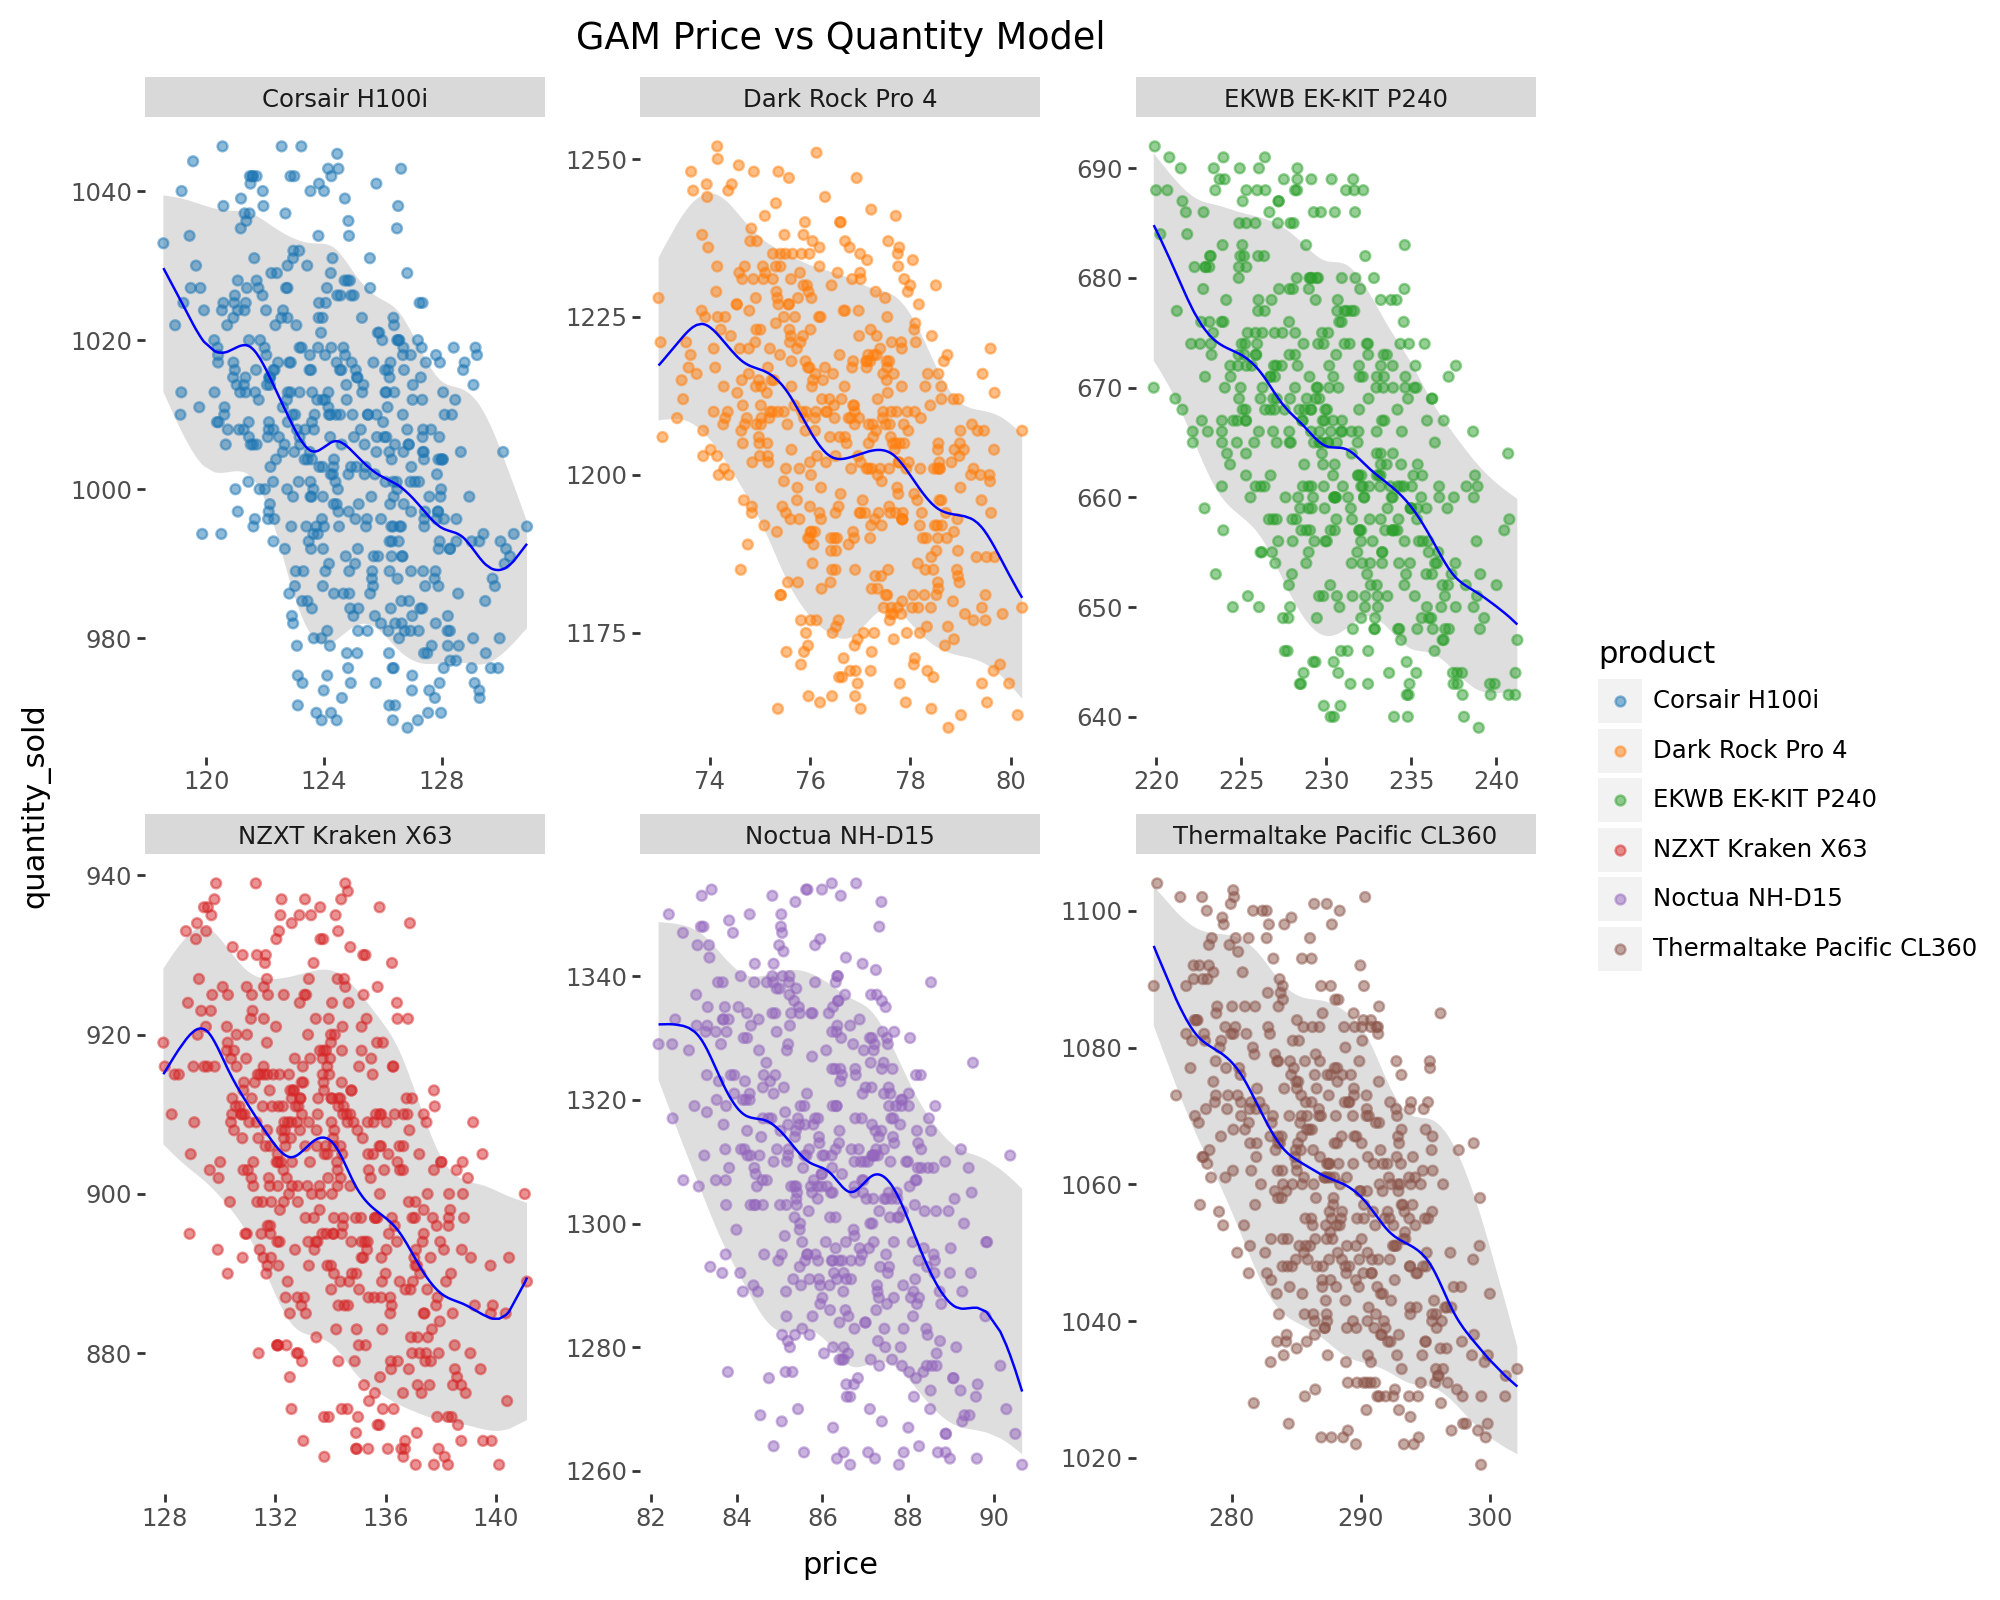

In [473]:
# Define a color palette manually (replace these with your desired colors)
color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

# Plot the data
ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='quantity_sold', color='product', group='product')
) + \
    geom_ribbon(aes(ymax="pred_0.975", ymin="pred_0.025"), fill="#d3d3d3", color="#FF000000", alpha=0.75, show_legend=False) + \
    geom_point(alpha=0.5) + \
    geom_line(aes(y="pred_0.5"), color="blue") + \
    facet_wrap('product', scales="free") + \
    labs(title="GAM Price vs Quantity Model") + \
    scale_color_manual(values=color_palette) + \
    theme(figure_size=(10, 8), panel_background=element_rect(fill='white', color='white'))

In [479]:
# Optimizing price for predicted daily revenue

# Optimize Price for Predicted Daily Revenue

# Calculate predicted revenue for each prediction column
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['price'] * all_gam_results[col]

# Calculate actual revenue
all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['quantity_sold']

# Display the modified DataFrame
all_gam_results

# Find optimal prices based on predicted revenue

# For median prediction (50th percentile)
best_50 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)) \
    .reset_index(level=0, drop=True)

# For 97.5th percentile prediction
best_975 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1)) \
    .reset_index(level=0, drop=True)

# For 2.5th percentile prediction
best_025 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1)) \
    .reset_index(level=0, drop=True)

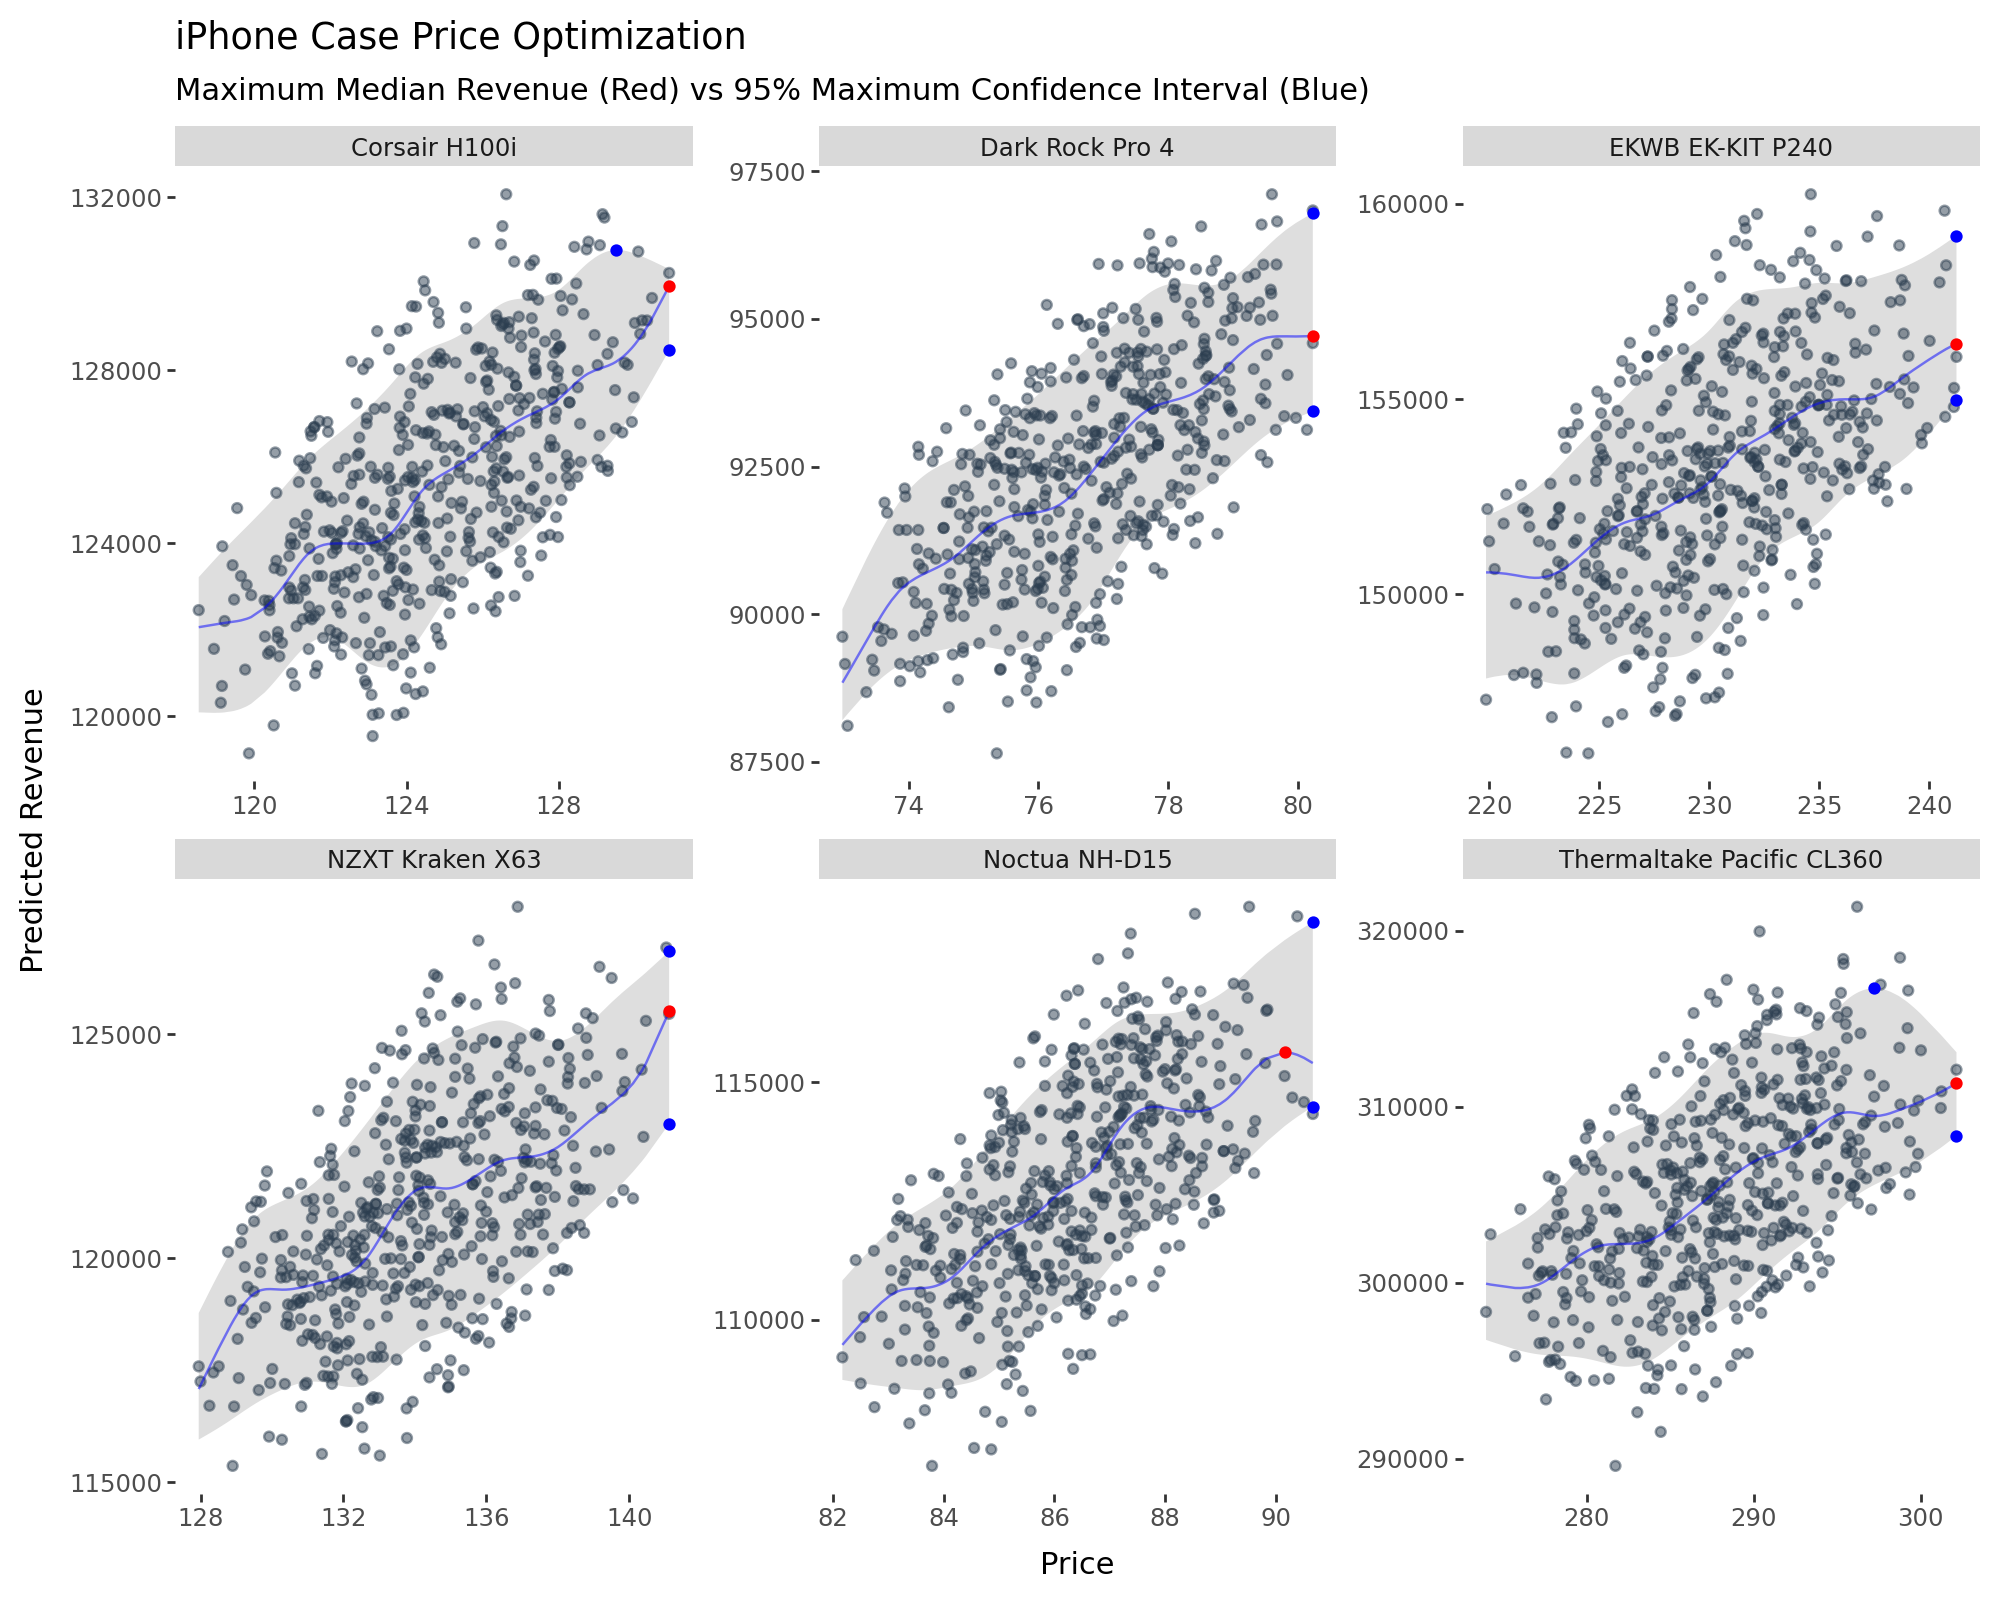

In [492]:
# Plot the data
ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='revenue_pred_0.5', color='product', group='product')
) + \
    geom_ribbon(aes(ymax = "revenue_pred_0.975", ymin = "revenue_pred_0.025"), fill="#d3d3d3", color="#FF000000", alpha=0.75, show_legend=False) + \
    geom_point(aes(y = 'revenue_actual'), alpha = 0.5, color = "#2C3E50") + \
    geom_line(aes(y="revenue_pred_0.5"), alpha = 0.5, color = "blue") + \
    geom_point(data = best_50, color = "red") + \
    geom_point(data = best_975, mapping = aes(y = 'revenue_pred_0.975'), color = "blue") +\
    geom_point(data = best_025, mapping = aes(y = 'revenue_pred_0.025'), color = "blue")+ \
    facet_wrap('product', scales = 'free') + \
    labs(title = "iPhone Case Price Optimization",
         subtitle = "Maximum Median Revenue (Red) vs 95% Maximum Confidence Interval (Blue)",
         x = "Price",
         y = "Predicted Revenue"
        ) + \
    scale_color_manual(values=color_palette) + \
    theme(figure_size=(10, 8), panel_background=element_rect(fill='white', color='white'))

In [493]:
# Displaying optimal points for the 50th, 2.5th, and 97.5th percentiles
best_50[['product', 'price', 'revenue_pred_0.5', 'revenue_pred_0.025', 'revenue_pred_0.975']]

product   price  revenue_pred_0.5  revenue_pred_0.025  \
1007              Corsair H100i  130.90     129942.083060       128459.582920   
525             Dark Rock Pro 4   80.23      94716.565917        93434.617420   
2009           EKWB EK-KIT P240  241.24     156422.919201       154978.773954   
1496            NZXT Kraken X63  141.12     125527.015999       123005.452314   
5                 Noctua NH-D15   90.16     115630.926139       114076.286115   
2501  Thermaltake Pacific CL360  302.14     311334.671523       308350.643200   

      revenue_pred_0.975  
1007       130335.973172  
525         96791.912717  
2009       159184.301867  
1496       126850.632343  
5          117998.528356  
2501       313099.382782

## Results

Based on the GAM model, the optimal prices for each product were identified at various prediction intervals:
 
- **50th Percentile (Median Prediction)**: Shows the price that yields the maximum expected revenue in an average scenario.
- **2.5th and 97.5th Percentiles**: Provide a range for revenue predictions, indicating conservative (2.5th percentile) and optimistic (97.5th percentile) revenue estimates.
 
The table above illustrates the optimal price points and revenue predictions for each product across different confidence levels.


## Conclusion
 
This analysis demonstrates the efficacy of GAM in price optimization, particularly in scenarios where demand fluctuates with price and promotional events. By leveraging GAM, we identified optimal price points for each product to maximize revenue under different market conditions.
 
**Key Takeaways**:
- **GAMs Flexibility**: GAMs offer a flexible approach to modeling demand, enabling more accurate predictions in non-linear price-demand relationships.
- **Event-Driven Pricing**: Promotional events significantly affect price elasticity, which is crucial for dynamic pricing strategies.
- **Data-Driven Decisions**: The optimized prices based on revenue predictions provide actionable insights for setting product prices in competitive markets.
 
This report highlights the importance of statistical modeling in price optimization and the potential of GAMs for complex, real-world applications.